# Análise de Sobrevivência no Naufrágio do Titanic

# Introdução

Neste projeto de Data Science, vamos explorar um conjunto de dados contendo informações detalhadas sobre os passageiros do Titanic. Utilizando técnicas de análise de dados e aprendizado de máquina, nosso objetivo é desenvolver um modelo preditivo para determinar a probabilidade de sobrevivência dos passageiros com base em diversas características como idade, sexo, classe social, entre outras.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt  
import sweetviz as sv

In [2]:
training = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([training,test])

In [3]:
# Informações
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [4]:
# Descricao
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [5]:
# Descricao por coluna
training.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

In [6]:
# Numerico vs categoricos
df_num = training[['Age','SibSp','Parch','Fare']]
df_cat = training[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

In [7]:
df_cat.Cabin
training['cabin_multiple'] = training.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
# Depois de olhar essa parte acima, dividir o cabin por número

training['cabin_multiple'].value_counts()
training['cabin_adv'] = training.Cabin.apply(lambda x: str(x)[0])

#numerico e nao numerico
training['numeric_ticket'] = training.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
training['ticket_letters'] = training.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)

In [8]:
# Usar o titulo das pessoas para facilitar
training.Name.head(50)
training['name_title'] = training.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
#mr., ms., master. etc

(889,)

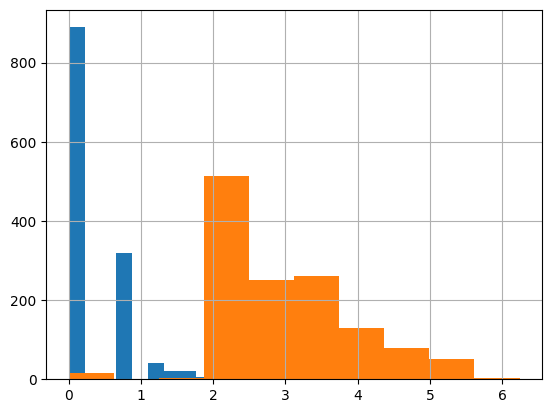

In [23]:
#Criar valores categóricos para facilitar
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['ticket_letters'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())


#Colocar a mediana no lugar de valores Nan
all_data.Age = all_data.Age.fillna(training.Age.median())


#Colocar a media no lugar de valores Nan
all_data.Fare = all_data.Fare.fillna(training.Fare.median())

#Tirar valores Nulls
all_data.dropna(subset=['Embarked'],inplace = True)

# Tentativa de normalizar os valores, não ajudou nesse caso
all_data['norm_sibsp'] = np.log(all_data.SibSp+1)
all_data['norm_sibsp'].hist()

# Normalizar o Fare (usado)
all_data['norm_fare'] = np.log(all_data.Fare+1)
all_data['norm_fare'].hist()

# converter fare para categórica()
all_data.Pclass = all_data.Pclass.astype(str)

# Dummy
all_dummies = pd.get_dummies(all_data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','name_title','train_test']])

# Dividir entre teste e treinamento
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)


y_train = all_data[all_data.train_test==1].Survived
y_train.shape

In [34]:
# Essa parte foi apenas para facilitar a visão dos valores
#df = pd.concat([X_train,y_train])
#report = sv.analyze(df)

# Exibir o relatório no navegador padrão
##report.show_html('sweetviz2_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz2_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [29]:
# Scale data 
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled

X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

X = X_train_scaled
#X.columns = X.columns.astype(str)

X = pd.get_dummies(X)  # Se houver variáveis categóricas
y = y_train

# Dividir os dados em conjunto de treinamento e conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Inicializar os modelos de classificação
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=5),
    "Neural Network": make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=5))
}

# Treinar e avaliar cada modelo
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    classification_rep = classification_report(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    results[name] = {"accuracy": accuracy, "classification_report": classification_rep, "confusion_matrix": conf_matrix}

# Imprimir resultados
for name, result in results.items():
    print(f"{name}:")
    print("Accuracy:", result['accuracy'])
    print("Classification Report:\n", result['classification_report'])
    #print("Confusion Matrix:\n", result['confusion_matrix'])


Logistic Regression:
Accuracy: 0.848314606741573
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       119
         1.0       0.79      0.75      0.77        59

    accuracy                           0.85       178
   macro avg       0.83      0.82      0.83       178
weighted avg       0.85      0.85      0.85       178

Decision Tree:
Accuracy: 0.7415730337078652
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.77      0.80       119
         1.0       0.60      0.68      0.63        59

    accuracy                           0.74       178
   macro avg       0.71      0.73      0.72       178
weighted avg       0.75      0.74      0.75       178

Random Forest:
Accuracy: 0.8089887640449438
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.82      0.85       119
         1.0       0.68     